In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier 

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/jonigooner/histogradient-with-optuna

ver8

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 828
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
unique_values = train.iloc[:1000].nunique()
categoricals = [col for col in  unique_values.index[unique_values < 10] if col!='target']
numeric = [col for col in test.columns if col not in categoricals]

train['mean_numeric'] = train[numeric].mean(axis=1)
train['std_numeric'] = train[numeric].std(axis=1)
train['min_numeric'] = train[numeric].min(axis=1)
train['max_numeric'] = train[numeric].max(axis=1)
train['sum_categoricals'] = train[categoricals].sum(axis=1)

test['mean_numeric'] = test[numeric].mean(axis=1)
test['std_numeric'] = test[numeric].std(axis=1)
test['min_numeric'] = test[numeric].min(axis=1)
test['max_numeric'] = test[numeric].max(axis=1)
test['sum_categoricals'] = test[categoricals].sum(axis=1)

features = features + ['mean_numeric','std_numeric','min_numeric','max_numeric','sum_categoricals']

In [8]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [9]:
train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)

Mem. usage decreased to 510.22 Mb (77.0% reduction)
Mem. usage decreased to 254.63 Mb (77.0% reduction)


In [10]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f280,f281,f282,f283,f284,mean_numeric,std_numeric,min_numeric,max_numeric,sum_categoricals
0,0.178223,0.435547,0.010231,0.202026,0.390137,0.324219,0.221680,0.738770,0.582520,0.343750,...,0,1,1,1,0,0.225586,0.211548,0.001878,0.997559,18
1,0.181274,0.476562,0.022415,0.283203,0.598145,0.349609,0.283447,0.721680,0.269043,0.208374,...,0,0,0,0,0,0.232178,0.212402,0.002733,0.994141,13
2,0.159668,0.451172,0.259766,0.365234,0.594727,0.413574,0.249268,0.642578,0.411133,0.246948,...,0,1,0,0,0,0.226685,0.211304,0.001809,0.995605,19
3,0.182373,0.520996,0.095337,0.327637,0.741699,0.358643,0.270020,0.601562,0.297852,0.252930,...,1,1,0,0,0,0.242554,0.217529,0.003166,0.990723,16
4,0.229370,0.336426,0.023514,0.301025,0.668945,0.481689,0.545898,0.667969,0.545898,0.202759,...,0,0,1,0,0,0.229492,0.213379,0.002766,0.991699,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.185425,0.525391,0.014946,0.203979,0.499023,0.431885,0.470459,0.731445,0.452148,0.211182,...,0,1,0,0,0,0.236206,0.217163,0.003513,0.987793,11
499996,0.183228,0.553223,0.008057,0.280762,0.636719,0.478027,0.450439,0.582520,0.517090,0.225098,...,0,0,1,0,0,0.226074,0.209229,0.002218,0.994141,15
499997,0.184692,0.533691,0.011215,0.201294,0.720703,0.472900,0.427490,0.589355,0.243896,0.413086,...,0,0,0,0,0,0.228760,0.205444,0.003893,0.993164,17
499998,0.227783,0.513184,0.178589,0.313721,0.665527,0.401367,0.183350,0.708008,0.575195,0.152832,...,0,1,0,0,0,0.230225,0.205444,0.002670,0.995605,7


In [11]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int8

In [12]:
del unique_values
del categoricals
del numeric

gc.collect()

40

# HGB

In [13]:
hgb_params = {
     'loss': 'binary_crossentropy',
    'learning_rate': 0.11252047021457195,
    'max_iter': 828, 
    'max_leaf_nodes': 7,
    'min_samples_leaf': 165,
    'l2_regularization':0.01565259604437387,
    'max_bins': 171,
    'verbose': VERBOSE
}

In [14]:
hgb_oof = np.zeros(train.shape[0])
hgb_pred = np.zeros(test.shape[0])
hgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold <12:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            hgb_params['random_state'] = inseed

            model = HistGradientBoostingClassifier(**hgb_params)
            model.fit(
                X_train, 
                y_train,
                
            )


            with open(f"hgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            

            hgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            hgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
           
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, hgb_oof[val_idx])
        print(f"fold {fold} - hgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

hgb_pred /= N_SPLITS
print(f"oof hgb_auc = {roc_auc_score(train[target], hgb_oof)}")

np.save("hgb_oof.npy", hgb_oof)
np.save("hgb_pred.npy", hgb_pred)

===== fold 0 =====
Binning 1.670 GB of training data: 18.052 s
Binning 0.186 GB of validation data: 0.648 s
Fitting gradient boosted rounds:
[1/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.66091, val loss: 0.66078, in 0.486s
[2/828] 1 tree, 7 leaves, max depth = 3, train loss: 0.63533, val loss: 0.63508, in 0.507s
[3/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.61475, val loss: 0.61438, in 0.631s
[4/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.59808, val loss: 0.59761, in 1.013s
[5/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.58451, val loss: 0.58398, in 0.492s
[6/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.57334, val loss: 0.57268, in 0.491s
[7/828] 1 tree, 7 leaves, max depth = 3, train loss: 0.56422, val loss: 0.56350, in 0.554s
[8/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.55669, val loss: 0.55590, in 0.503s
[9/828] 1 tree, 7 leaves, max depth = 4, train loss: 0.55044, val loss: 0.54957, in 0.480s
[10/828] 1 tree, 7 leaves, max depth = 4

# OOF predictions

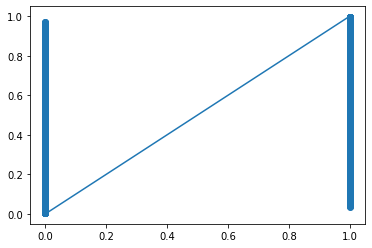

In [15]:
plt.plot(train[target], train[target])
plt.scatter(train[target], hgb_oof)

In [16]:
del train
del hgb_oof
gc.collect()

20

# Submission

In [17]:
submission[target] = hgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.757222
1,1000001,0.268561
2,1000002,0.893072
3,1000003,0.846733
4,1000004,0.266429
...,...,...
499995,1499995,0.970345
499996,1499996,0.813217
499997,1499997,0.304472
499998,1499998,0.479768


# Log

seeds

2017 ver4
2018 ver5
2019 ver6
2020 ver7
2021 ver8